<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# High Dimensional & Deep Learning : Image classification  on MNIST dataset.

## Objectives
In this TP you will learn to : 
* Write multilayer perceptron and convolutional network with `Keras`and `Tensorflow`
* Understand how `convolutional`, `max pooling`, `stride` and `padding`layers work.
* Use these models for image classification.

## Libraries

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import pandas as pd
import numpy as np
import time

import tensorflow.keras.utils as ku
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.preprocessing.image as k


from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow
tensorflow.__version__

'2.0.0-beta1'

This code lines allow you to check if your computer is using CPU or GPU ressources. <br>
**Warning** : You won't be able to use GPU if another notebook is open and still uses GPU.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3508524878892250817
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7479611247874164188
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10843622605
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7698750337766998385
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17133607307608685416
physical_device_desc: "device: XLA_GPU device"
]


## Dataset 

The dataset that will be used in this TP is the [MNIST DataBase](http://yann.lecun.com/exdb/mnist/).<br>
It is composed of 70.000 images (60.000 for learning, 10.000 for test) of 28x28 pixels of handwritten digits from 0 to 9.<br>

These data are directly available on the `Keras` library.

In [4]:
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
N_train, N_x_pixels, N_y_pixels = X_train.shape
N_test = X_test.shape[0]
N_classes = len(set(Y_train))

print("Train data : %d images  (%d/%d pixels)" %(N_train, N_x_pixels, N_y_pixels))
print("Test data : %d images  (%d/%d pixels)" %(N_test, N_x_pixels, N_y_pixels))

Train data : 60000 images  (28/28 pixels)
Test data : 10000 images  (28/28 pixels)


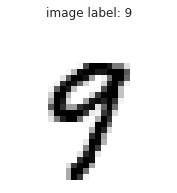

In [5]:
sample_index = 45
fig =plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.imshow(X_train[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
ax.set_title("image label: %d" % Y_train[sample_index])
ax.grid(False)
ax.axis('off')
plt.show()

### Image example

## Image classification with Multi Layer Perceptron model.

We will first try to learn an image classifier with a MLP model with the following architecture.

* A Dense layer with 128 neurons and *relu* activation function
* A Dropout Layer with 20% drop rate
* A Dense layer with 128 neurons and *relu* activation function
* A Dropout Layer with 20% drop rate
* A Dense layer with 10 neurons (Number of classes ) and *softmax* activation function

### Data format

Some modifications are required on the data to use them with our model. 

The first layer is a Dense Layer, which handles 1D vectors as an input. We must first reshape the 2D 28x28 images as a 1D $28*28=784$ vector.

In [6]:
X_train_flatten = X_train.reshape((N_train, N_x_pixels*N_y_pixels)) / 255.
X_test_flatten = X_test.reshape((N_test, N_x_pixels*N_y_pixels)) / 255.
N_dim_flatten = X_train_flatten.shape[1]
print("Dimensions of flatten train images : %d X %d" %(X_train_flatten.shape))
print("Dimensions of flatten test images : %d X %d" %(X_test_flatten.shape))
print(np.max(X_train_flatten))

Dimensions of flatten train images : 60000 X 784
Dimensions of flatten test images : 10000 X 784
1.0


### Architecture 

In [7]:
# Définition du réseau
model = km.Sequential()
model.add(kl.Dense(128, activation='relu', input_shape=(N_dim_flatten,)))
model.add(kl.Dropout(0.2))
model.add(kl.Dense(128, activation='relu'))
model.add(kl.Dropout(0.2))
model.add(kl.Dense(N_classes, activation='softmax'))
# Réumé
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


**Q** The summary displays the number of pararameters/weigths of the model. Retrieve these values with the formulas seen in the course.

128 : nombre de neurones par couche

Calcul des nombres de paramètres : $(28\times 28 + 1) \times 128 = 100480$ : il y a un terme de biais supplémentaire.

Dropout : aucun paramètre à apprendre car il désactive aléatoirement 20% des neurones.

Dense_2 : $128 \times 129 = 16512$ (un terme de biais sur la deuxième couche).

Dense_3 : $10 \times 129 = 1290$ (car 10 classes, toujours un terme de biais supplémentaire)

### Training

You will now instantiate your model by defining :
* An optimizer : `RMSprop`
* a loss function : `Categorical crossentropy`
* Metric : This argument is an option, it allows to compute the metric if you want to check the evolution of the training. Here we choose to compute the accuracy during the training.

**Note** : In Keras you can choose either "sparse_categorical_crossentropy" or "categorical_crossentropy" loss. The former handel 1D (NX1) vectors where each entry contains the label of the data, i.e [0,3,5,9,3,4,...]. The latter handle only one-hot encoding of this vector, ie a 2D vectors (NXN_classes) matrices. Keras has a `to_categorical` functions which allows to convert a vector to its one-hot encoding representation.

In [8]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=ko.RMSprop(),
              metrics=['accuracy'])

In [9]:
batch_size = 256
epochs=10
ts = time.time()
history = model.fit(X_train_flatten, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_flatten, Y_test))
te = time.time()
t_train_mpl = te-ts

W1015 14:07:08.539095 139955286411072 deprecation.py:323] From /usr/local/insa/anaconda/envs/GPU-TF2/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 78us/sample - loss: 0.4378 - accuracy: 0.8709 - val_loss: 0.1844 - val_accuracy: 0.9449
Epoch 2/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.1949 - accuracy: 0.9417 - val_loss: 0.1275 - val_accuracy: 0.9616
Epoch 3/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.1468 - accuracy: 0.9557 - val_loss: 0.1051 - val_accuracy: 0.9676
Epoch 4/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.1181 - accuracy: 0.9638 - val_loss: 0.0910 - val_accuracy: 0.9729
Epoch 5/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.1043 - accuracy: 0.9688 - val_loss: 0.0847 - val_accuracy: 0.9731
Epoch 6/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0888 - accuracy: 0.9727 - val_loss: 0.0827 - val_accuracy: 0.9732
Epoch 7/10
60000/60000 [==============================] 

### Results

Test loss: 0.0739936572625069
Test accuracy: 0.9788
Time Running: 19.50 seconds


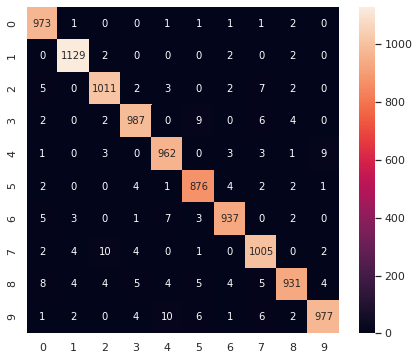

In [10]:
score_mpl = model.evaluate(X_test_flatten, Y_test, verbose=0)
predict_mpl = model.predict(X_test_flatten)
print('Test loss:', score_mpl[0])
print('Test accuracy:', score_mpl[1])
print("Time Running: %.2f seconds" %t_train_mpl )
fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_mpl.argmax(1))), annot=True, fmt="d")


**Question** What can you say about these results?

**R** Les résultats ne sont pas vraiments bons : précision de 85% et le 4 est perçu comme un 9.

**Exercise** Normalize the data in order to have values between 0 and 1 and run again the learning. What can you say about these results?

C'est beaucoup mieux.

## Convolutional Layers

In this part we will use convolution layers to build a convolutional classifier.


#### Data

The convolution architecure takes as input images and no not 1D vectors. However, some data formating are still required.

A third dimension is required : the `channels` dimension which will allow to describe each pixel. In our case this dimension's size is only 1 because the images are only defined with grey scale. However for colour images, each pixel is coded with several values (Images are generally encoded with 3 values (RGB channels)). 

Hence, we need to reshape the images from a 28x28 dimension to a 28X28X1 dimension

In [11]:
X_train_conv = np.expand_dims(X_train,axis=-1)
X_test_conv = np.expand_dims(X_test,axis=-1)
X_train_conv.shape

(60000, 28, 28, 1)

### Edge detection

We will first check the transformation applied by a convolution layer.

In the following code, we define a convolutional network with  only one filter for which we manually define the weights.

In [12]:

conv_filter = np.array([
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
    ])

def my_init_filter(shape, conv_filter = conv_filter, dtype=None, partition_info=None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
my_init_filter(0).shape

conv_edge = km.Sequential([
    kl.Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter, input_shape=(28, 28, 1))   
])

 **Q** Note that in  `my_init_filter` two dimensions have been added to the conv filter. What do these dimensions represent?
 
 **R** Les deux dimensions ajoutées représentent la profondeur et la dimension du batch.
 
 The following code allows to display the image, the filter and the convoluted image.

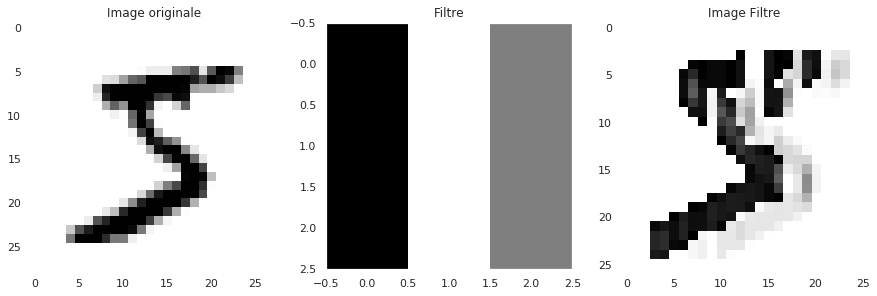

In [13]:
img_in = X_train_conv
img_out = conv_edge.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0], cmap="binary")
ax0.set_title("Image originale")
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8), cmap="binary")
ax1.set_title("Filtre")
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8), cmap="binary")
ax2.set_title("Image Filtre")
ax2.grid(False)


**Q** What do you see? Are the output image coherent according to the designed filter ?

**R** Le filtre détecte les bords sur la gauche. Le résultat est cohérent : sur le bas du 5, la partie "haute" sur la gauche ressort plus noire (c'est le bord du chiffre) ; la partie basse sur la droite ressort blanche.

**Exercise** Change the code in order to test different filters (to detect horizontal edge, etc...)

### Strides and Padding

We will now study the effect on `strides` and `padding` arguments on the image.


In [14]:
conv_filter = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ])

def my_init_filter(shape, conv_filter = conv_filter, dtype=None, partition_info = None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
my_init_filter(0).shape

conv_sp = km.Sequential([
    kl.Conv2D(kernel_size=(3, 3), filters=1, kernel_initializer=my_init_filter, input_shape=(28, 28, 1),
           strides=2, padding="valid") ])

**Q** What is the effect of the convolutional filter defined here ? 

**R** Il élimine les bords.

(28, 28)
(13, 13)


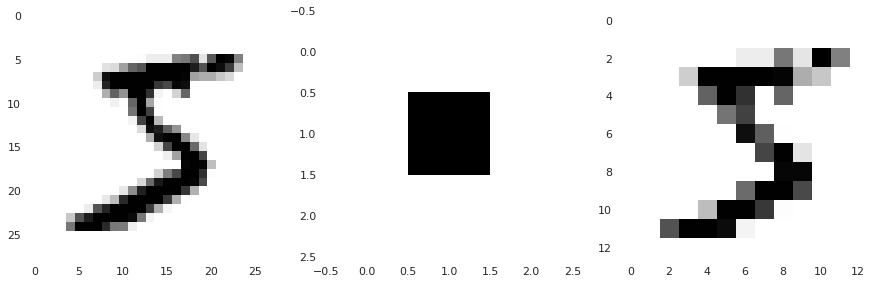

In [15]:
img_in = X_train_conv
img_out = conv_sp.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax0.grid(False)
print(img_in[0,:,:,0].shape)
norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8),
           cmap="binary");
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8),
           cmap="binary");
print(img_out[0,:,:,0].shape)
ax2.grid(False)

**Exercise** Check the dimension of the output images. Are they coherent? <br>

Oui, dimension 13 x 13 x 1 car le filtre a une taille de 3 x 3 donc 28 - 1 - 1 = 26 et stride de 2 --> 13, dernière dimension de 1 car un seul filtre.

**Exercise** Change both *stride* and *padding* arguments and understand the effect of these changes.

### Max Pooling

**Exercice** Write a similar code than above to check and understand the behaviour of the `max pooling` layer.

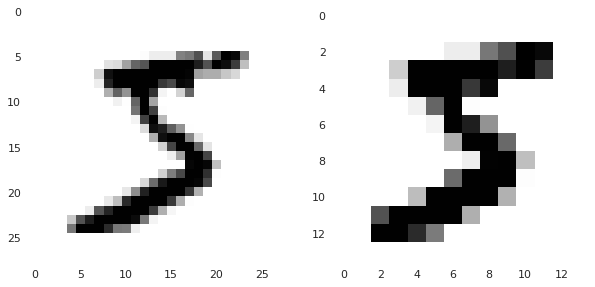

In [16]:
# %load solutions/max_pooling.py
conv_mp = km.Sequential([ kl.MaxPool2D(pool_size=(2,2))])

img_in = X_train_conv
img_out = conv_mp.predict(img_in)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax0.grid(False)

ax1.imshow(img_out[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax1.grid(False)

**Questions** What are the dimension of the output image? Is this normal?

**R** MaxPool prend par défaut le stride égal à la dimension du filtre (ici 2 x 2) donc c'est normal

## *Convolutional Network (ConvNet)*

We will now build convolutional networks and see the performances on this kind of model on  image classification problems.

### LeNet5

We first test the  LeNet5 model, proposed by LeCun et al.

In [17]:
LeNet5model = km.Sequential()
LeNet5model.add(kl.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'tanh',
input_shape = (28,28,1)))
LeNet5model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
LeNet5model.add(kl.Conv2D(filters = 16, kernel_size = 5,strides = 1, activation = 'tanh'))
LeNet5model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
LeNet5model.add(kl.Flatten())
LeNet5model.add(kl.Dense(units = 120, activation = 'tanh'))
LeNet5model.add(kl.Dense(units = 84, activation = 'tanh'))
LeNet5model.add(kl.Dense(units = 10, activation = 'softmax'))

LeNet5model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

**Exercise** Retrieve 'manually' the number of parameters of this model.

Couche 1 : chaque filtre est de taille 5x5=25 + 1 poids de biais, pour 6 filtres : soit au total 26x6=156

Tous les max_pooling ont 0 paramètres car on n'a rien à apprendre : pas de paramètre.

Couche 2 : Chaque filtre possède 6 dimensions (à cause des sorties de la couche précédente, qui possédait 6 filtres) : donc 16 x (5x5x6 +1) car toujours 1 poids de biais et des filtres de taille 5x5

Couche dense 1 : 257x120 = 30840

Idem pour les différentes couches : il y a (nombre de param à l'entrée + 1) x (nombre de param à la sortie) paramètres à estimer.

**Question** What can you say about the total number of parameters compared with the MLP model defined before? Which layer has the highest number of parameters?

**R** Il y a beaucoup moins de paramètres à apprendre dans le réseau convolutionnel (on réduit la dimension dans la partie convolution) et c'est le même filtre qui est utilisé pour l'ensemble de l'image.
Les couches denses (les mêmes que précédemment) ont le plus de paramètres.

In [18]:
# Apprentissage
batch_size=128
epochs=30
LeNet5model.compile(loss="sparse_categorical_crossentropy",
              optimizer=ko.Adadelta(),
              metrics=['accuracy'])
ts=time.time()
LeNet5model.fit(X_train_conv, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_conv, Y_test))
te=time.time()
t_train_conv = te-ts

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 3s 50us/sample - loss: 2.3657 - accuracy: 0.1152 - val_loss: 2.3173 - val_accuracy: 0.1416
Epoch 2/30
60000/60000 [==============================] - 3s 43us/sample - loss: 2.2840 - accuracy: 0.1622 - val_loss: 2.2510 - val_accuracy: 0.1967
Epoch 3/30
60000/60000 [==============================] - 3s 44us/sample - loss: 2.2268 - accuracy: 0.2127 - val_loss: 2.1984 - val_accuracy: 0.2431
Epoch 4/30
60000/60000 [==============================] - 3s 44us/sample - loss: 2.1774 - accuracy: 0.2576 - val_loss: 2.1493 - val_accuracy: 0.2854
Epoch 5/30
60000/60000 [==============================] - 3s 43us/sample - loss: 2.1294 - accuracy: 0.2997 - val_loss: 2.1004 - val_accuracy: 0.3261
Epoch 6/30
60000/60000 [==============================] - 3s 43us/sample - loss: 2.0812 - accuracy: 0.3409 - val_loss: 2.0505 - val_accuracy: 0.3693
Epoch 7/30
60000/60000 [==============================] 

**Q** Why is the training time longer?

**R** C'est plus long car il y a plus d'epoch ici, et chaque epoch est plus long que précédemment, peut-être à cause des activations tanh au lieu de ReLU.

#### Results

Test loss: 0.9444749485015869
Test accuracy: 0.7837
Time Running: 80.97 seconds


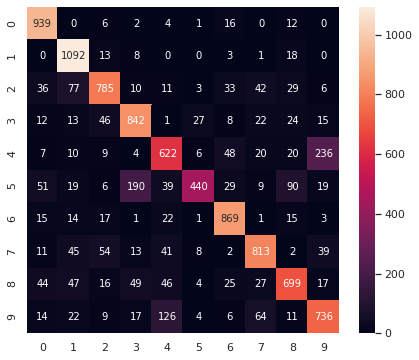

In [19]:
score_conv = LeNet5model.evaluate(X_test_conv, Y_test, verbose=0)
predict_conv = LeNet5model.predict(X_test_conv)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])
print("Time Running: %.2f seconds" %t_train_conv )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_conv.argmax(1))), annot=True, fmt="d")


### A more complex architecture

#### Network

We will now design a more complex architecture to try to improve the results of the classification :

* A Conv2D layer with 32-3X3 filters and the `Relu` activation function.
* A Conv2D layer with 642-3X3 filters and the `Relu` activation function.
* A MaxPooling layer with a 2X2 window.
* A Dropout layer with a 25% drop rate.
* A flatten layer.
* A Dense layer with 128 neurons  and the `Relu` activation function.
* A Dropout layer with a 50% drop rate.
* A Dense layer with 10 neurons  and the `softmax` activation function.


**Exercise** Define this model and train it.

In [37]:
# %load solutions/mnist_conv_architecture.py

model = km.Sequential()
model.add(kl.Conv2D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu',
input_shape = (28,28,1)))
model.add(kl.Conv2D(filters = 64, kernel_size = 3,strides = 1, activation = 'relu'))
model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
model.add(kl.Dropout(rate=0.25))
model.add(kl.Flatten())
model.add(kl.Dense(units = 128, activation = 'relu'))
model.add(kl.Dropout(rate=0.5))
model.add(kl.Dense(units = 10, activation = 'softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)             

In [38]:
# Apprentissage
batch_size=128
epochs=30
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=ko.Adam(lr=0.8*1e-3),
              metrics=['accuracy'])
ts=time.time()
model.fit(X_train_conv, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_conv, Y_test))
te=time.time()
t_train_conv = te-ts

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 5s 77us/sample - loss: 1.8090 - accuracy: 0.8291 - val_loss: 0.0720 - val_accuracy: 0.9770
Epoch 2/30
60000/60000 [==============================] - 4s 71us/sample - loss: 0.1148 - accuracy: 0.9668 - val_loss: 0.0485 - val_accuracy: 0.9855
Epoch 3/30
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0868 - accuracy: 0.9747 - val_loss: 0.0429 - val_accuracy: 0.9872
Epoch 4/30
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0706 - accuracy: 0.9784 - val_loss: 0.0418 - val_accuracy: 0.9866
Epoch 5/30
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0580 - accuracy: 0.9823 - val_loss: 0.0390 - val_accuracy: 0.9876
Epoch 6/30
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0557 - accuracy: 0.9834 - val_loss: 0.0412 - val_accuracy: 0.9871
Epoch 7/30
60000/60000 [==============================] 

Test loss: 0.04178367975105739
Test accuracy: 0.9917
Time Running: 133.62 seconds


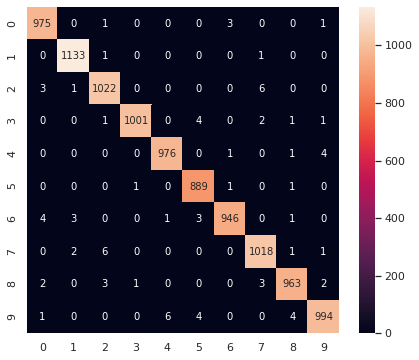

In [39]:
score_conv = model.evaluate(X_test_conv, Y_test, verbose=0)
predict_conv = model.predict(X_test_conv)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])
print("Time Running: %.2f seconds" %t_train_conv )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_conv.argmax(1))), annot=True, fmt="d")

**Q** Comment the results.

**R** C'est beau. Il y a très peu de mauvaises prédictions.

**Q** How to improve them?

**R** Pour améliorer les résultats, on peut changer le learning rate dans l'optimizer ou mettre plus d'epochs.